# Markov Chain Monte Carlo

- By Yuan-Sen Ting, April 2025, for ASTRON 5550

When analyzing astronomical data, we frequently need to explore complex probability distributions that describe physical parameters like stellar temperatures, galaxy masses, or cosmological constants. While the sampling techniques we've explored previously are powerful, they often struggle with high-dimensional distributions that are common in modern astronomy. This tutorial introduces Markov Chain Monte Carlo (MCMC) methods, which have revolutionized statistical inference in astronomy by enabling efficient exploration of complex parameter spaces.

## Prerequisites

Before proceeding with this tutorial, you should be familiar with:
- Basic concepts of probability and Bayesian statistics
- Fundamental sampling methods (from the previous tutorial)
- Python programming fundamentals
- Core concepts from the MCMC lecture materials

## What You'll Learn

This tutorial explores advanced sampling techniques that form the foundation of modern Bayesian inference in astronomy:

1. **The Metropolis-Hastings Algorithm**:
   - Master the mechanics of this fundamental MCMC technique
   - Understand how proposal distributions affect sampling efficiency
   - Apply the algorithm to estimate stellar parameters from simulated data

2. **Gibbs Sampling**:
   - Learn when and why to use this specialized sampling approach
   - Implement the algorithm for multivariate distributions

3. **MCMC Diagnostics**:
   - Analyze chain convergence, burn-in periods, and autocorrelation
   - Calculate effective sample sizes to quantify sampling efficiency

Let's begin by setting up our Python environment:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import tqdm
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Configure high-resolution plots with clear fonts
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 20
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)

## The Metropolis-Hastings Algorithm
The Metropolis-Hastings algorithm provides a powerful framework for sampling from complex probability distributions when direct sampling isn't feasible. It's particularly valuable in astronomy where we often work with high-dimensional parameter spaces and complex likelihood functions.

### The Physical Intuition

Before diving into mathematics, let's build some intuition. Imagine an astronomer exploring an unfamiliar mountain range, searching for the highest peak. With limited visibility and no map, a reasonable strategy might be:

1. Look around from your current position
2. Randomly pick a direction and take a step
3. If the new position is higher, definitely stay there
4. If the new position is lower, occasionally still stay there (to avoid getting stuck on small hills)
5. Repeat this process, recording your path along the way

This exploration strategy is analogous to how the Metropolis-Hastings algorithm works. The algorithm constructs a "random walk" through parameter space that, despite its randomness, spends more time in high-probability regions. By recording this path (the "chain"), we obtain samples that approximate our target distribution.

### Mathematical Foundation

The theoretical foundations of MCMC rest on two key principles that guarantee convergence to our target distribution:

#### 1. Detailed Balance

For a Markov chain to converge to a specific distribution, it must satisfy detailed balance. This condition ensures that transitions between states maintain the desired equilibrium distribution. Mathematically, detailed balance requires:

$$p(\mathbf{x}) T(\mathbf{x}, \mathbf{x}') = p(\mathbf{x}') T(\mathbf{x}', \mathbf{x})$$

Where $p$ represents the target distribution, and $T$ denotes the transition probabilities.

#### 2. Ergodicity

The chain must be ergodic, meaning every possible state can be reached from any other state given enough steps. This property ensures the chain will fully explore the parameter space rather than getting trapped in a subset of states.

The remarkable strength of MCMC lies in its ability to sample from essentially any posterior distribution, regardless of its complexity or dimensionality. The Metropolis algorithm, through its carefully designed acceptance probability, ensures that detailed balance is satisfied with respect to our target distribution. This guarantees that our target posterior is at least a candidate for the stationary distribution of the Markov chain. When combined with ergodicity, which is almost always guaranteed in real applications, we have the complete foundation for correctly sampling from our target distribution.

### The Metropolis Algorithm: Step by Step

Formally, the Metropolis algorithm implements a transition probability $T(\mathbf{x}, \mathbf{x}') = q(\mathbf{x}'|\mathbf{x})A(\mathbf{x}, \mathbf{x}')$, where $q$ is our symmetric proposal distribution and $A$ is the acceptance probability:

$$A(\mathbf{x}, \mathbf{x}') = \min\left(1, \frac{p(\mathbf{x}'|\mathcal{D})}{p(\mathbf{x}|\mathcal{D})}\right)$$

The power of this approach lies in its dependence only on the ratio of posterior probabilities, eliminating the need to compute the often intractable normalization constant. Since the posterior is proportional to the likelihood times the prior, $p(\mathbf{x}|\mathcal{D}) \propto p(\mathcal{D}|\mathbf{x})p(\mathbf{x})$, we can compute this ratio without ever calculating the evidence term $p(\mathcal{D})$.

The implementation follows these simple steps:

1. **Initialize**: Choose a starting point $\mathbf{x}^{(0)}$ in the parameter space.

2. **For each iteration** $t = 1, 2, \ldots, T$:
   
   a. **Propose**: Generate a candidate state $\mathbf{x}'$ from a symmetric proposal distribution centered at the current state:
      $\mathbf{x}' \sim q(\mathbf{x}'|\mathbf{x}^{(t-1)})$, where $q(\mathbf{x}'|\mathbf{x}) = q(\mathbf{x}|\mathbf{x}')$.
   
   b. **Compute**: Calculate the acceptance probability:
      $A(\mathbf{x}^{(t-1)}, \mathbf{x}') = \min\left(1, \frac{p(\mathbf{x}'|\mathcal{D})}{p(\mathbf{x}^{(t-1)}|\mathcal{D})}\right)$
   
   c. **Accept/Reject**: Draw a uniform random number $u \sim \mathcal{U}(0,1)$:
      - If $u \leq A(\mathbf{x}^{(t-1)}, \mathbf{x}')$, accept the proposal: $\mathbf{x}^{(t)} = \mathbf{x}'$
      - Otherwise, reject and stay at the current position: $\mathbf{x}^{(t)} = \mathbf{x}^{(t-1)}$

3. **Return**: The sequence $\{\mathbf{x}^{(0)}, \mathbf{x}^{(1)}, \ldots, \mathbf{x}^{(T)}\}$ as samples from the posterior distribution (typically discarding some initial portion as "burn-in").



## Toy Example: Estimating the Sample Mean

To build practical understanding, let's apply the Metropolis algorithm to a concrete astronomical problem: estimating the mean of a stellar population from an observed sample.

### The Astronomical Context

In many astronomical settings, we observe a population of objects (stars, galaxies, etc.) and wish to infer the underlying population parameters. While the true distribution might be complex, we'll start with a simplified scenario where:

1. We have observations of stars drawn from a normal distribution with unknown mean $\mu$ and known standard deviation $\sigma = 1$.
2. Our prior beliefs about $\mu$ are represented by a Cauchy distribution, which has heavier tails than a normal distribution, allowing for more robust inference.

This setup mimics real astronomical scenarios where we might have limited observations of a stellar population and need to infer its properties while accounting for prior knowledge.

### Mathematical Formulation

In Bayesian terms, we want to compute the posterior distribution:

$$p(\mu | \{x_i\}) \propto p(\{x_i\} | \mu) \times p(\mu)$$

Where:
- $\{x_i\}$ is our observed sample
- $p(\{x_i\} | \mu)$ is the likelihood of observing our data given $\mu$
- $p(\mu)$ is our prior on $\mu$

For a normal distribution with known $\sigma = 1$, the likelihood is:

$$p(\{x_i\} | \mu) = \prod_{i=1}^N \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{(x_i - \mu)^2}{2}\right)$$

Our Cauchy prior is:

$$p(\mu) = \frac{1}{\pi\gamma} \frac{1}{1 + \left(\frac{\mu-\mu_0}{\gamma}\right)^2}$$

where $\mu_0 = 0$ is the location parameter and $\gamma = 3$ is the scale parameter.

Taking the logarithm of the posterior, we get:

$$\log p(\mu | \{x_i\}) \propto \sum_{i=1}^N \log p(x_i | \mu) + \log p(\mu)$$

This log-posterior will be the target for our Metropolis algorithm.

In [2]:
# Generate a sample from a normal distribution with a fixed variance of one
n = 1000
loc_true = 1
x_sample = np.random.normal(loc=loc_true, scale=1, size=n)

# Let's examine the first few values and basic statistics
print(f"First 10 observations: {x_sample[:10]}")
print(f"Sample mean: {np.mean(x_sample):.4f}")
print(f"Sample standard deviation: {np.std(x_sample):.4f}")
print(f"True mean (to be estimated): {loc_true}")

First 10 observations: [1.49671415 0.8617357  1.64768854 2.52302986 0.76584663 0.76586304
 2.57921282 1.76743473 0.53052561 1.54256004]
Sample mean: 1.0193
Sample standard deviation: 0.9787
True mean (to be estimated): 1


Let's visualize our sample data to understand what we're working with. This will give us a sense of the distribution we're trying to estimate the mean of.

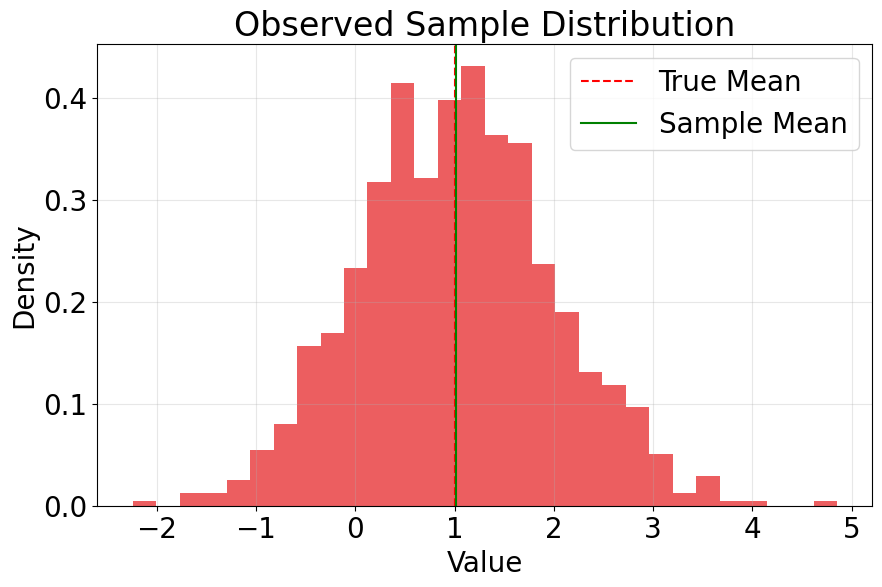

In [3]:
# Visualize the sample
plt.figure(figsize=(10, 6))
plt.hist(x_sample, bins=30, density=True, alpha=0.7)
plt.axvline(x=loc_true, color='r', linestyle='--', label='True Mean')
plt.axvline(x=np.mean(x_sample), color='g', linestyle='-', label='Sample Mean')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Observed Sample Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Implementing the Log-Posterior Function

The first step in our MCMC implementation is to define the log-posterior function. Working in log space provides numerical stability, especially when dealing with products of small probabilities.

Our log-posterior combines:
1. The log-likelihood, which measures how well a given mean $\mu$ explains our data
2. The log-prior, which encodes our prior beliefs about reasonable values of $\mu$

In [4]:
def log_posterior(mu, x_sample):
    """
    Calculate the log posterior probability for a given mean value.
    
    Parameters:
    -----------
    mu : float
        The proposed mean value
    x_sample : array
        The observed data sample
        
    Returns:
    --------
    log_post : float
        The log posterior probability
    """
    # Log likelihood (normal distribution)
    log_likelihood = np.sum(stats.norm.logpdf(x_sample, loc=mu, scale=1))
    
    # Log prior (Cauchy distribution)
    log_prior = stats.cauchy.logpdf(mu, loc=0, scale=3)
    
    # Log posterior (up to a constant)
    return log_likelihood + log_prior

### The Proposal Mechanism

In the Metropolis algorithm, we need a way to propose new values to explore the parameter space. The proposal distribution is crucial for efficient sampling. For this problem, we'll use a normal distribution centered at the current value of $\mu$, with a standard deviation $\nu$ that controls the "step size" of our exploration.

We'll implement the proposal function first, then later experiment with different values of $\nu$ to see how they affect the algorithm's performance.

In [5]:
def proposal(mu, nu):
    """
    Generate a proposal for the next state in the Metropolis algorithm.
    
    Parameters:
    -----------
    mu : float
        Current value of the mean
    nu : float
        Standard deviation of the proposal distribution
        
    Returns:
    --------
    mu_proposed : float
        Proposed new value for the mean
    """
    return stats.norm.rvs(loc=mu, scale=nu, size=1).item()

### Implementing the Metropolis Algorithm

Now we'll implement the Metropolis algorithm, which is a special case of the more general Metropolis-Hastings algorithm where the proposal distribution is symmetric. Since our normal proposal distribution satisfies $q(\mathbf{x}'|\mathbf{x}) = q(\mathbf{x}|\mathbf{x}')$, we can simplify the acceptance ratio to only involve the posterior ratio.

Our function will:

1. Initialize a chain at a starting value
2. Generate proposals using our symmetric proposal function
3. Accept or reject each proposal based solely on the posterior ratio
4. Keep track of the chain and the acceptance rate

The acceptance ratio is a key diagnostic that helps us evaluate and tune the algorithm. A very high or very low acceptance rate typically indicates inefficient sampling.

In [6]:
def metropolis_hastings(mu_init, nu, n_iterations):
    """
    Run the Metropolis-Hastings algorithm to sample from the posterior.
    
    Parameters:
    -----------
    mu_init : float
        Initial value for the mean
    nu : float
        Standard deviation of the proposal distribution
    n_iterations : int
        Number of iterations to run
        
    Returns:
    --------
    chain : list
        The Markov chain of samples
    accept_ratio : float
        Proportion of proposed values that were accepted
    """
    # Initialize the chain with the starting value
    chain = [mu_init]
    mu = mu_init
    accept_count = 0
    
    # Run the chain for n iterations
    for i in tqdm.tqdm(range(n_iterations)):
        # Step 1: Propose a new value
        mu_star = proposal(mu, nu)
        
        # Step 2: Calculate acceptance ratio (in log space for stability)
        log_ratio = log_posterior(mu_star, x_sample) - log_posterior(mu, x_sample)
        alpha = min(1, np.exp(log_ratio))
        
        # Step 3: Accept or reject
        u = np.random.uniform()
        if u < alpha:
            mu = mu_star
            accept_count += 1
        
        # Step 4: Add the current state to the chain
        chain.append(mu)
    
    # Calculate the acceptance ratio
    accept_ratio = accept_count / n_iterations * 100
    
    return chain, accept_ratio

Let's run our algorithm with three different proposal widths ($\nu$) to see how this parameter affects the sampling performance. The proposal width controls how "adventurous" our exploration is:

- **Small $\nu$ (0.01)**: Takes small steps, high acceptance rate but slow exploration
- **Medium $\nu$ (0.1)**: Moderate steps, balanced exploration and acceptance
- **Large $\nu$ (0.5)**: Takes large steps, explores quickly but with many rejections

For each case, we'll run 10,000 iterations starting from $\mu_\text{init} = 0$.

In [7]:
# Define parameters for our experiment
nu_values = [0.01, 0.1, 0.5]
mu_init = 0
n_iterations = 10000
results = {}

# Run the Metropolis-Hastings algorithm for each proposal width
for nu in nu_values:
    print(f"\nRunning Metropolis-Hastings with proposal width ν = {nu}")
    chain, accept_ratio = metropolis_hastings(mu_init, nu, n_iterations)
    results[nu] = (chain, accept_ratio)
    print(f"Acceptance ratio: {accept_ratio:.1f}%")


Running Metropolis-Hastings with proposal width ν = 0.01


100%|██████████| 10000/10000 [00:01<00:00, 6790.82it/s]


Acceptance ratio: 90.0%

Running Metropolis-Hastings with proposal width ν = 0.1


100%|██████████| 10000/10000 [00:01<00:00, 6772.37it/s]


Acceptance ratio: 35.9%

Running Metropolis-Hastings with proposal width ν = 0.5


100%|██████████| 10000/10000 [00:01<00:00, 6679.21it/s]

Acceptance ratio: 8.2%


### Visualizing the Chains

Let's visualize the first 1000 samples from each chain to understand how the proposal width ($\nu$) affects the sampling behavior. 

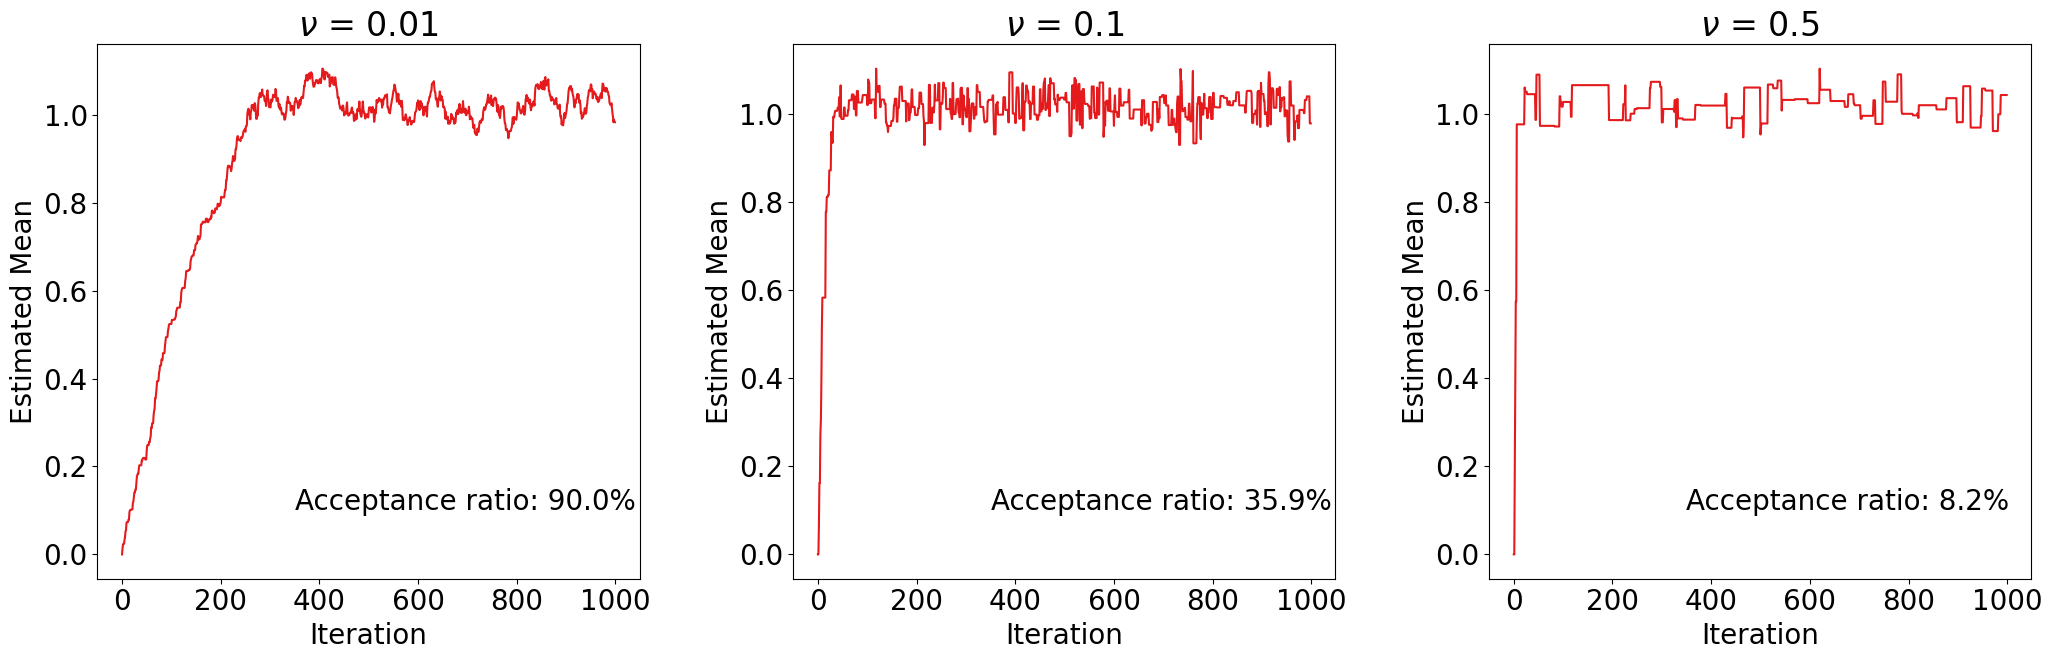

In [8]:
# Create a figure with three subplots for our different values of nu
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

# For each value of nu, plot the first 1000 samples of the chain
for index, nu in enumerate(nu_values):
    ax = axes[index]
    chain, accept_ratio = results[nu]
    
    # Plot only the first 1000 samples to see the initial behavior
    ax.plot(chain[:1000]) 
    
    # Add labels and title
    ax.set_title(f"$\\nu$ = {nu}")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Estimated Mean")
    
    # Add the acceptance ratio as text in the plot
    ax.text(350, 0.1, f"Acceptance ratio: {accept_ratio:.1f}%", fontsize=20)

plt.tight_layout()
plt.show()

### Autocorrelation and Effective Sample Size

Autocorrelation in a Markov chain measures how dependent each sample is on previous samples. When we have perfectly independent samples, the standard error of our estimates decreases proportionally to $1/\sqrt{N}$. However, MCMC samples are inherently correlated, which means each new sample provides less "new information" than an independent sample would.

For a sequence of samples $\{X_0, X_1, X_2, ...\}$, the theoretical autocorrelation at lag $k$ is defined as:

$$ R(k) = \frac{E[(X_t - \mu)(X_{t+k} - \mu)]}{\sigma^2} $$

where $\mu = E[X_t]$ is the mean and $\sigma^2 = E[(X_t - \mu)^2]$ is the variance of the stationary distribution. Intuitively, this tells us how much knowing the value at position $t$ helps predict the value at position $t+k$.

In practice, we estimate the autocorrelation from our finite chain using:

$$ \hat{R}(k) = \frac{\sum_{t=1}^{N-k} (X_t - \bar{X})(X_{t+k} - \bar{X})}{\sum_{t=1}^{N} (X_t - \bar{X})^2} $$

where $\bar{X}$ is the sample mean of the chain.

The autocorrelation function provides insights into the efficiency of our MCMC sampler:
- In an ideal scenario with completely independent samples, $R(k) = 0$ for all $k > 0$
- In MCMC, we typically observe a decaying autocorrelation as the lag increases
- The rate of this decay directly impacts how efficiently our chain explores parameter space

The effective sample size (ESS) quantifies how many truly independent samples our correlated chain represents:

$$ \text{ESS} = \frac{N}{1 + 2\sum_{k=1}^{\infty}R(k)} $$

In practice, we truncate this infinite sum at a reasonable lag where the autocorrelation becomes negligible.

Let's analyze the autocorrelation and ESS for each of our chains.

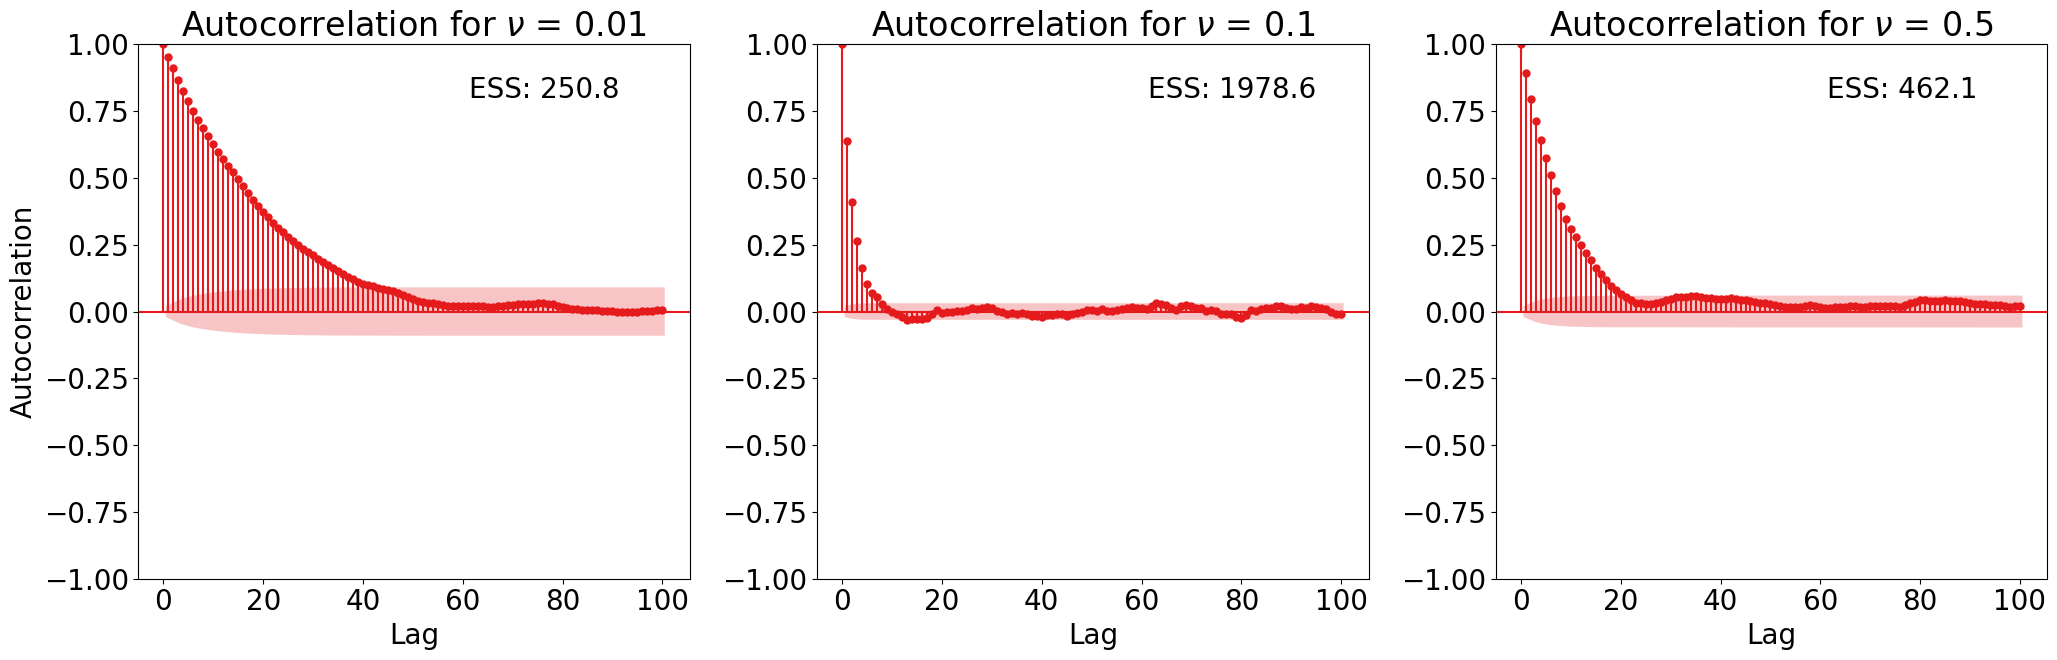

In [9]:
import statsmodels.api as sm

def calculate_ess(samples):
    """
    Calculate the Effective Sample Size for a Markov chain.
    
    Parameters:
    -----------
    samples : array
        The Markov chain samples
        
    Returns:
    --------
    ess : float
        The effective sample size
    """
    # Calculate autocorrelation up to lag 100
    # Using fft=True for more efficient computation
    N = len(samples)
    autocorr_values = sm.tsa.acf(samples, nlags=100, fft=True)
    
    # Calculate ESS using the formula
    # ESS = N / (1 + 2*sum(autocorrelations))
    return N / (1 + 2 * sum(autocorr_values[1:]))

# Create a figure for autocorrelation plots
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

for index, nu in enumerate(nu_values):
    ax = axes[index]
    chain, _ = results[nu]
    
    # Discard the first 500 samples as burn-in
    chain = chain[500:]
    
    # Plot the autocorrelation function
    sm.graphics.tsa.plot_acf(chain, lags=100, ax=ax)
    ax.set_title(f"Autocorrelation for $\\nu$ = {nu}")
    ax.set_xlabel("Lag")
    
    if index == 0:
        ax.set_ylabel("Autocorrelation")
    
    # Calculate and display the effective sample size
    ess = calculate_ess(chain)
    ax.annotate(f"ESS: {ess:.1f}", xy=(0.6, 0.9), xycoords='axes fraction')

plt.tight_layout()
plt.show()

The autocorrelation plots and effective sample size (ESS) calculations reveal important insights about our Markov chains:

The plots we generated show the autocorrelation function (ACF) for each chain. This visualizes how correlation between samples decays as the lag (distance between samples) increases:

- **At lag 0**: The autocorrelation is always 1, as each sample is perfectly correlated with itself.
- **At positive lags**: Values closer to 1 indicate stronger correlation; values near 0 indicate little correlation.
- **Blue shaded region**: Represents the 95% confidence interval for the null hypothesis that there is no correlation.

We used the `statsmodels` library for efficient computation of autocorrelation:

- **`sm.tsa.acf()`**: Calculates the autocorrelation function for a time series.
  - The `nlags=100` parameter specifies that we calculate autocorrelations up to lag 100.
  - The `fft=True` parameter uses Fast Fourier Transform for more efficient computation, which is especially important for longer sequences.

- **`sm.graphics.tsa.plot_acf()`**: Creates a visualization of the autocorrelation function.
  - This function not only plots the autocorrelation values but also adds confidence intervals.

Our custom `calculate_ess()` function implements the effective sample size formula:
$$\text{ESS} = \frac{N}{1 + 2\sum_{k=1}^{100}R(k)}$$

We truncate the sum at lag 100 since autocorrelations typically become negligible at higher lags, and estimates become increasingly uncertain.

Let's compare the autocorrelation patterns across different proposal widths:
 
1. **Small Proposal Width ($\nu = 0.01$)**:
    - Shows high autocorrelation persisting even at large lags
    - The slow decay indicates that samples remain correlated for many iterations
    - Results in a very low effective sample size relative to the chain length
 
2. **Large Proposal Width ($\nu = 0.5$)**:
    - Shows an erratic autocorrelation pattern
    - The chain often remains stuck at the same value for many iterations
    - Also results in a relatively low effective sample size
 
3. **Moderate Proposal Width ($\nu = 0.1$)**:
    - Shows more rapid decay in autocorrelation
    - Samples become effectively independent at shorter lags
    - Results in a higher effective sample size, indicating more efficient sampling
 
This analysis confirms our earlier observation about the optimal proposal width. The chain with $\nu = 0.1$ not only shows good mixing behavior visually but also quantitatively provides the most effective samples per iteration.

Before applying burn-in and thinning, we should formally assess whether our chains have converged to the target distribution. While visual inspection gives us some intuition, statistical tests provide more rigorous evidence.

#### The Geweke Test

The Geweke test compares the means of different segments of a single MCMC chain. If the chain has converged to its stationary distribution, different portions should exhibit similar statistical properties.

The test works by:
1. Comparing the mean of the first portion (typically 10% of the chain) with the mean of the last portion (typically 50%)
2. Computing a Z-score that accounts for the autocorrelation within each segment
3. Testing if this Z-score is consistent with a standard normal distribution

If the Z-score has magnitude less than 2 (roughly corresponding to a 95% confidence interval), we have evidence that the chain has likely converged.

Let's implement the Geweke test for our chains:

In [10]:
from statsmodels.tsa.stattools import acf

def geweke_test(chain, first=0.1, last=0.5, max_lag=20):
    """
    Perform the Geweke test for MCMC convergence.
    
    Parameters:
    -----------
    chain : array
        The Markov chain samples
    first : float
        Fraction of chain to use for the first segment (default: 0.1)
    last : float
        Fraction of chain to use for the last segment (default: 0.5)
    max_lag : int
        Maximum lag for autocorrelation estimation
        
    Returns:
    --------
    z_score : float
        The Geweke Z-score
    """
    n = len(chain)
    
    # Define the segments
    n_a = int(first * n)
    n_b = int(last * n)
    
    segment_a = chain[:n_a]
    segment_b = chain[-n_b:]
    
    # Calculate means
    mean_a = np.mean(segment_a)
    mean_b = np.mean(segment_b)
    
    # Estimate spectral densities at frequency zero (accounting for autocorrelation)
    def spectral_density(x):
        acf_values = acf(x, nlags=max_lag, fft=True)
        # Apply window function (1 - k/max_lag) to reduce noise at higher lags
        window = 1 - np.arange(max_lag+1)/max_lag
        # Calculate spectral density
        var_x = np.var(x)
        s0 = var_x * (1 + 2 * np.sum(window[1:] * acf_values[1:]))
        return s0
    
    s_a = spectral_density(segment_a)
    s_b = spectral_density(segment_b)
    
    # Calculate Z-score
    z_score = (mean_a - mean_b) / np.sqrt(s_a/n_a + s_b/n_b)
    
    return z_score

# Test convergence for each chain
for nu in nu_values:
    chain, _ = results[nu]
    z = geweke_test(chain)
    print(f"Geweke Z-score for ν = {nu}: {z:.3f}")
    
    # Interpret the result
    if abs(z) < 2:
        print("  Evidence suggests the chain has converged.")
    else:
        print("  Evidence suggests the chain may not have converged.")

Geweke Z-score for ν = 0.01: -3.396
  Evidence suggests the chain may not have converged.
Geweke Z-score for ν = 0.1: -1.247
  Evidence suggests the chain has converged.
Geweke Z-score for ν = 0.5: -0.611
  Evidence suggests the chain has converged.


Let's analyze the Geweke test results for our three chains:

- **Small Proposal Width ($\nu = 0.01$)**:
  - $Z$-score = $-3.4$ (magnitude $> 2$)
  - Evidence suggests the chain has **not** converged
  - This confirms our earlier observation that small steps lead to inefficient exploration

- **Moderate Proposal Width ($\nu = 0.1$)**:
  - $Z$-score = $-1.2$ (magnitude $< 2$)
  - Evidence suggests the chain has converged
  - This supports our visual assessment that this proposal width provides good mixing
 
- **Large Proposal Width ($\nu = 0.5$)**:
  - $Z$-score = $-0.6$ (magnitude $< 2$)
  - Evidence suggests the chain has converged
  - Despite the jagged appearance, the chain appears to have reached its stationary distribution
 
While the Geweke test is useful for single-chain diagnostics, a more robust approach is to run multiple chains and compare them using the Gelman-Rubin statistic ($\hat{R}$). This diagnostic assesses whether different chains have converged to the same distribution by comparing within-chain and between-chain variance.


#### Gelman-Rubin Convergence Diagnostic

While the Geweke test examines a single chain, a more robust approach involves running multiple chains from different starting points and comparing their behavior. If all chains converge to the same distribution, they should become statistically indistinguishable after an appropriate burn-in period.

The Gelman-Rubin diagnostic formalizes this intuition by comparing within-chain variance to between-chain variance. For our parameter μ, we run multiple chains and calculate:

1. **Within-chain variance ($W$)**: The average of the variances of each individual chain
2. **Between-chain variance ($B$)**: The variance of the chain means, multiplied by the chain length

The Gelman-Rubin statistic R̂ is then given by:

$$\hat{R} = \sqrt{\frac{W + (B-W)/n}{W}} = \sqrt{1 + \frac{B-W}{nW}}$$

When the chains have converged to the same distribution:
- $B$ should approximately equal $W$
- Thus, $\hat{R}$ should approach 1
 
Values of $\hat{R}$ below 1.1 (or even 1.05 for more stringent criteria) are generally considered evidence of convergence, while values substantially above 1 indicate that the chains have not yet converged.
 

In [11]:
def gelman_rubin(chains):
    """
    Calculate the Gelman-Rubin convergence diagnostic (R̂).
    
    Parameters:
    -----------
    chains : list of arrays
        List containing multiple chains (each an array of samples)
        
    Returns:
    --------
    R_hat : float
        The Gelman-Rubin statistic (values close to 1 indicate convergence)
    """
    # Number of chains and length of each chain
    m = len(chains)
    n = len(chains[0])
    
    # Calculate the mean of each chain
    chain_means = np.array([np.mean(chain) for chain in chains])
    
    # Calculate the variance of each chain
    chain_vars = np.array([np.var(chain) for chain in chains])
    
    # Calculate overall mean
    overall_mean = np.mean(chain_means)
    
    # Within-chain variance W (average of individual variances)
    W = np.mean(chain_vars)
    
    # Calculate variance of the chain means
    var_chain_means = np.sum((chain_means - overall_mean)**2) / m
    
    # Between-chain variance B
    B = n * var_chain_means
    
    # Calculate R̂ using the formula from the lecture notes
    R_hat = np.sqrt((W + (B-W)/n) / W)
    # Alternatively: R_hat = np.sqrt(1 + (B-W)/(n*W))
    
    return R_hat

# Run multiple chains for the Gelman-Rubin test
n_chains = 4
n_iterations = 5000
chains = []

print("Running multiple chains for Gelman-Rubin diagnostic...")
for i in range(n_chains):
    # Use different starting points for each chain
    mu_init = np.random.uniform(-3, 3)
    chain, _ = metropolis_hastings(mu_init, 0.1, n_iterations)
    # Discard burn-in
    chains.append(np.array(chain[500:]))
    print(f"Chain {i+1} complete, starting from μ = {mu_init:.2f}")

# Calculate and interpret the Gelman-Rubin statistic
r_hat = gelman_rubin(chains)
print(f"Gelman-Rubin R̂ = {r_hat:.4f}")

if r_hat < 1.1:
    print("Chains have converged (R̂ < 1.1)")
else:
    print("Chains may not have converged (R̂ ≥ 1.1)")

Running multiple chains for Gelman-Rubin diagnostic...


100%|██████████| 5000/5000 [00:00<00:00, 6806.08it/s]


Chain 1 complete, starting from μ = 2.34


100%|██████████| 5000/5000 [00:00<00:00, 6826.78it/s]


Chain 2 complete, starting from μ = -1.14


100%|██████████| 5000/5000 [00:00<00:00, 6527.53it/s]


Chain 3 complete, starting from μ = 2.11


100%|██████████| 5000/5000 [00:00<00:00, 6810.99it/s]

Chain 4 complete, starting from μ = -0.51
Gelman-Rubin R̂ = 1.0000
Chains have converged (R̂ < 1.1)


Our result of $\hat{R} = 1.0000$ indicates excellent convergence of our chains. This value, extremely close to 1, provides strong evidence that our chains have all converged to the same stationary distribution, despite starting from different initial points.

By combining both the Geweke test and the Gelman-Rubin diagnostic, we have comprehensive evidence that our MCMC implementation with a moderate proposal width ($\nu = 0.1$) produces reliable samples from the target posterior distribution.

For our posterior analysis, we'll proceed with the moderate proposal width ($\nu = 0.1$) chain, applying a burn-in of $500$ samples to ensure we're safely in the convergence region.

True mean: 1
Posterior mean: 1.02
Posterior standard deviation: 0.03
95% credible interval: [0.96, 1.08]


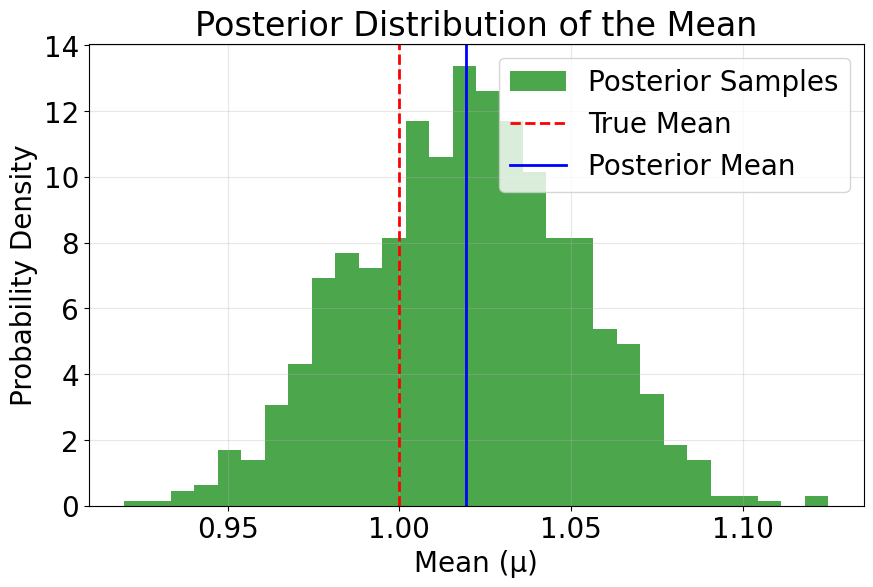

In [12]:
# Select the chain with moderate proposal width
chain = results[0.1][0]

# Apply burn-in: discard the first 500 samples
burn_in = 500
chain_post_burnin = chain[burn_in:]

# Apply thinning: keep every 10th sample
thinning = 10
thinned_chain = chain_post_burnin[::thinning]

# Create histogram of the posterior
plt.figure(figsize=(10, 6))
plt.hist(thinned_chain, bins=30, density=True, alpha=0.7, color='green', 
         label='Posterior Samples')
plt.axvline(x=loc_true, color='red', linestyle='--', linewidth=2, label='True Mean')
plt.axvline(x=np.mean(thinned_chain), color='blue', linewidth=2, label='Posterior Mean')

# Add labels and title
plt.xlabel('Mean (μ)')
plt.ylabel('Probability Density')
plt.title('Posterior Distribution of the Mean')
plt.legend()
plt.grid(True, alpha=0.3)

# Print summary statistics with simpler formatting
print(f"True mean: {loc_true}")
print(f"Posterior mean: {np.mean(thinned_chain):.2f}")
print(f"Posterior standard deviation: {np.std(thinned_chain):.2f}")

# Round credible interval to 2 decimal places
ci_low = np.percentile(thinned_chain, 2.5)
ci_high = np.percentile(thinned_chain, 97.5)
print(f"95% credible interval: [{ci_low:.2f}, {ci_high:.2f}]")

plt.show()

### Interpreting the Posterior Distribution

The histogram displays our posterior distribution for the mean ($\mu$) after applying burn-in and thinning to our MCMC chain. This distribution represents our updated beliefs about $\mu$ given our prior (Cauchy distribution) and the observed data.

Key observations:

1. **Posterior Mean**: The center of our posterior distribution represents our best estimate of $\mu$ based on the available information.

2. **True Mean**: The red dashed line shows the true value that we used to generate the data. The posterior distribution correctly captures this value within its high probability region.

3. **Uncertainty Quantification**: The width of the distribution reflects our uncertainty about $\mu$. This is one of the key advantages of Bayesian methods—they naturally provide a complete picture of parameter uncertainty.

4. **Credible Interval**: The 95% credible interval indicates the range within which we believe $\mu$ lies with 95% probability, given our data and prior.

As the sample size increases, we would expect:
- The posterior distribution to become narrower (more certain)
- The posterior mean to move closer to the true value
- The influence of the prior to diminish

This example demonstrates how MCMC enables Bayesian inference even when analytical solutions aren't available. Through the Metropolis algorithm, we've successfully sampled from the posterior distribution and gained insights about our parameter of interest.

## Gibbs Sampling

While the Metropolis algorithm provides a general approach for MCMC sampling, there are situations where we can achieve more efficient sampling by leveraging knowledge about the structure of our target distribution. Gibbs sampling is one such specialized technique that excels when we can sample from the conditional distributions of our parameters.

### The Intuition Behind Gibbs Sampling

Imagine we have a multivariate distribution with parameters $(x_1, x_2, ..., x_n)$. Instead of proposing moves in the full parameter space, Gibbs sampling:

1. Updates one parameter at a time
2. Samples directly from the conditional distribution of that parameter
3. Cycles through all parameters sequentially

This approach is particularly powerful when:
- The conditional distributions have analytical forms that are easy to sample from
- Parameters exhibit strong correlations that make exploration difficult using standard Metropolis

### Sampling from a Bivariate Gaussian Distribution

Let's illustrate Gibbs sampling with a concrete example: sampling from a bivariate Gaussian distribution. This example is particularly instructive because:
1. We can derive the conditional distributions analytically
2. We can easily control the correlation structure to demonstrate its impact on sampling efficiency

Consider sampling from a bivariate Gaussian distribution with zero mean and correlation coefficient $\rho$:

$$\begin{pmatrix} x_1 \\ x_2 \end{pmatrix} \sim \mathcal{N}\left(\mathbf{0}, \begin{bmatrix} 1 & \rho \\ \rho & 1 \end{bmatrix}\right)$$

To implement Gibbs sampling, we need the conditional distributions $p(x_1 | x_2)$ and $p(x_2 | x_1)$. For a bivariate Gaussian, these are also Gaussian distributions.

Using the standard formula for conditional distributions of multivariate Gaussians, we can derive:

$$p(x_1 | x_2) = \mathcal{N}(\rho x_2, 1-\rho^2)$$
$$p(x_2 | x_1) = \mathcal{N}(\rho x_1, 1-\rho^2)$$

These expressions tell us that:
1. The conditional mean of $x_1$ given $x_2$ is proportional to $x_2$ (scaled by $\rho$)
2. The conditional variance is $1-\rho^2$ (smaller when variables are highly correlated)
3. The same pattern applies for the conditional distribution of $x_2$ given $x_1$

The Gibbs sampling procedure would alternate between:
1. Sample $x_1^{(t+1)} \sim \mathcal{N}(\rho x_2^{(t)}, 1-\rho^2)$
2. Sample $x_2^{(t+1)} \sim \mathcal{N}(\rho x_1^{(t+1)}, 1-\rho^2)$

Let's implement this algorithm and explore how the correlation coefficient $\rho$ affects sampling performance.

In [13]:
# Define a Gibbs sampler for a bivariate Gaussian distribution
def gibbs_sampler(n_samples, rho):
    """
    Perform Gibbs sampling for a bivariate Gaussian distribution.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to draw
    rho : float
        Correlation coefficient of the bivariate Gaussian
        
    Returns:
    --------
    samples : array
        Array of sampled points with shape (n_samples, 2)
    """
    # Initialize storage for samples
    samples = np.zeros((n_samples, 2))
    
    # Start from an arbitrary point
    x1 = 100  # Intentionally far from the true distribution's center
    x2 = 100  # to demonstrate convergence behavior
    
    # Run the Gibbs sampling algorithm
    for i in range(n_samples):
        # Sample x1 from its conditional distribution given x2
        # For bivariate Gaussian: p(x1|x2) = N(rho*x2, 1-rho^2)
        x1 = np.random.normal(loc=rho*x2, scale=np.sqrt(1-rho**2))
        
        # Sample x2 from its conditional distribution given x1
        # For bivariate Gaussian: p(x2|x1) = N(rho*x1, 1-rho^2)
        x2 = np.random.normal(loc=rho*x1, scale=np.sqrt(1-rho**2))
        
        # Store the sample
        samples[i, :] = [x1, x2]
        
    return samples

In [14]:
# Define functions to visualize the samples and sampling behavior
def plot_samples(samples, n_burn, n_thin):
    """
    Plot the samples obtained from Gibbs sampling.
    
    Parameters:
    -----------
    samples : array
        Array of sampled points
    n_burn : int
        Number of initial samples to discard (burn-in period)
    n_thin : int
        Thinning factor to reduce autocorrelation
    """
    
    plt.figure(figsize=(10, 10))
    
    # Create a scatter plot of the samples with a joint distribution using seaborn
    sns.set_style('white')
    sns.jointplot(
        x=samples[n_burn::n_thin, 0], 
        y=samples[n_burn::n_thin, 1], 
        kind='scatter', 
        alpha=0.5
    )
    
    # Add axis labels
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    
    # Add contours of the true bivariate normal distribution
    x = np.linspace(-3, 3, 100)
    y = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x, y)
    
    # Create the position mesh for the bivariate normal
    pos = np.dstack((X, Y))
    
    # Define the bivariate normal distribution
    rv = stats.multivariate_normal(mean=[0, 0], cov=[[1, rho], [rho, 1]])
    
    # Calculate the PDF values
    Z = rv.pdf(pos)
    
    # Add contours
    plt.contour(X, Y, Z, colors='k', alpha=0.5)
    

def plot_chains(samples, n_burn):
    """
    Visualize the progression of the Markov chain.
    
    Parameters:
    -----------
    samples : array
        Array of sampled points
    n_burn : int
        Number of initial samples to visualize for burn-in assessment
    """
    # Plot the chains to visualize burn-in and correlation
    plt.figure(figsize=(15, 7))
    
    # First subplot: initial burn-in period
    plt.subplot(1, 2, 1)
    plt.plot(samples[:n_burn, 0], label='$x_1$')
    plt.plot(samples[:n_burn, 1], label='$x_2$')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.title(f'Burn-in Period (First {n_burn} Iterations)')
    plt.legend(frameon=False)
    
    # Second subplot: chain after burn-in (just 100 samples for clarity)
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(n_burn, n_burn+100), samples[n_burn:n_burn+100, 0], label='$x_1$')
    plt.plot(np.arange(n_burn, n_burn+100), samples[n_burn:n_burn+100, 1], label='$x_2$')
    plt.xlabel('Iteration')
    plt.title('Post Burn-in (100 Iterations)')
    plt.legend(frameon=False)
    
    plt.tight_layout()

### Impact of Correlation on Gibbs Sampling Efficiency

Let's investigate how the correlation coefficient $\rho$ affects the performance of Gibbs sampling. We'll examine two scenarios:

1. **High correlation ($\rho = 0.95$)**: When variables are strongly correlated, their conditional distributions have:
   - Conditional means that depend strongly on the other variable: $\mathcal{N}(0.95 \times \text{other variable}, ...)$
   - Small conditional variances: $\mathcal{N}(..., 1 - 0.95^2 = 0.0975)$
   
2. **Low correlation ($\rho = 0.1$)**: When variables are weakly correlated, their conditional distributions have:
   - Conditional means that depend weakly on the other variable: $\mathcal{N}(0.1 \times \text{other variable}, ...)$
   - Larger conditional variances: $\mathcal{N}(..., 1 - 0.1^2 = 0.99)$
   
For each scenario, we'll generate samples, visualize the sampling pattern, and analyze how the correlation affects convergence and mixing.

<Figure size 1000x1000 with 0 Axes>

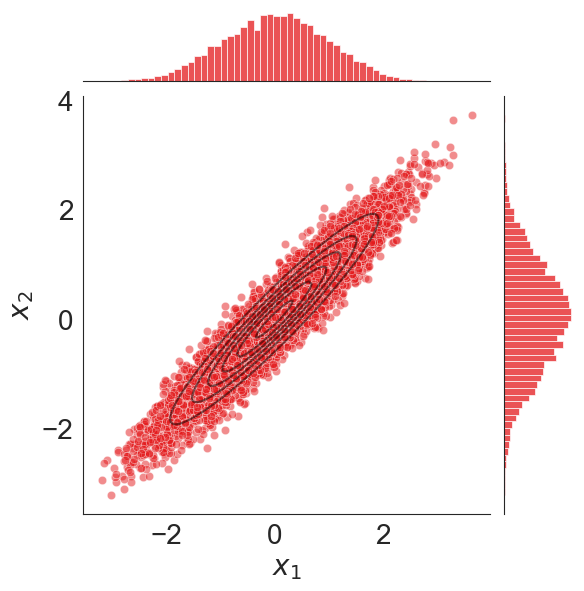

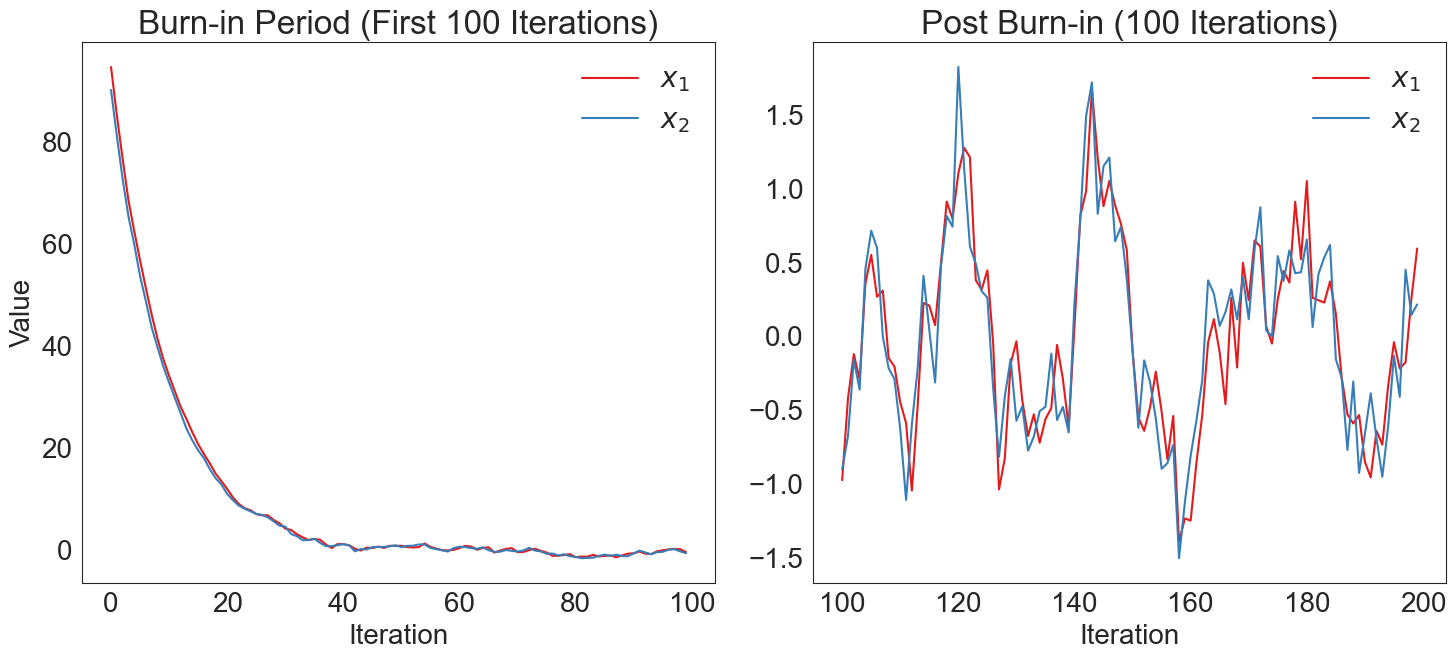

In [15]:
# Run Gibbs sampling with high correlation
n_samples = 10000
rho = 0.95
samples_high_corr = gibbs_sampler(n_samples, rho)

# Visualize the samples and burn-in period
plot_samples(samples_high_corr, n_burn=100, n_thin=1)
plot_chains(samples_high_corr, n_burn=100)

### High Correlation Case (ρ = 0.95)

The sampling behavior with high correlation (ρ = 0.95) reveals several important characteristics of Gibbs sampling:

With ρ = 0.95, the conditional distributions become:
- $p(x_1 | x_2) = \mathcal{N}(0.95 \times x_2, 0.0975)$
- $p(x_2 | x_1) = \mathcal{N}(0.95 \times x_1, 0.0975)$

The high value of ρ creates strong dependencies between variables. Each new value of $x_1$ is almost linearly determined by the previous value of $x_2$ (with just a small random component), and vice versa.

#### The "Random Walk" Effect

The scatter plot reveals a distinctive pattern where the samples trace the elliptical contours of the bivariate Gaussian. This occurs because:

1. The strong correlation creates an elongated elliptical distribution
2. Gibbs sampling only moves parallel to the coordinate axes (first updating $x_1$, then $x_2$)
3. This creates a characteristic "zigzag" pattern as the sampler alternately updates each dimension

This zigzag pattern is particularly inefficient for exploring highly correlated distributions. While the sampler does eventually cover the full distribution, it takes many small steps to move along the major axis of correlation.

#### Slow Convergence and Mixing

The chain trace plots show that:

1. The burn-in period takes longer - both variables need more iterations to reach their stationary distributions
2. Even after burn-in, consecutive samples remain highly dependent on each other
3. The chain exhibits slow "mixing," meaning it takes many iterations to generate effectively independent samples

These characteristics highlight a key limitation of Gibbs sampling: while it always accepts proposed moves (unlike Metropolis), it can still be inefficient when variables are strongly correlated.

Now let's examine how the behavior changes with a lower correlation coefficient.

<Figure size 1000x1000 with 0 Axes>

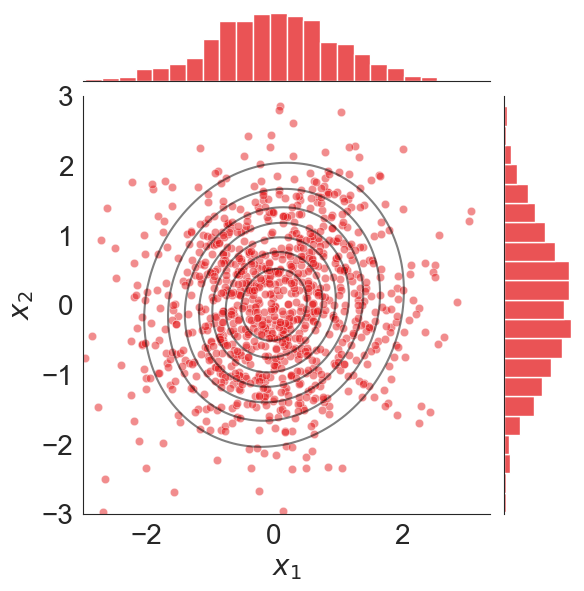

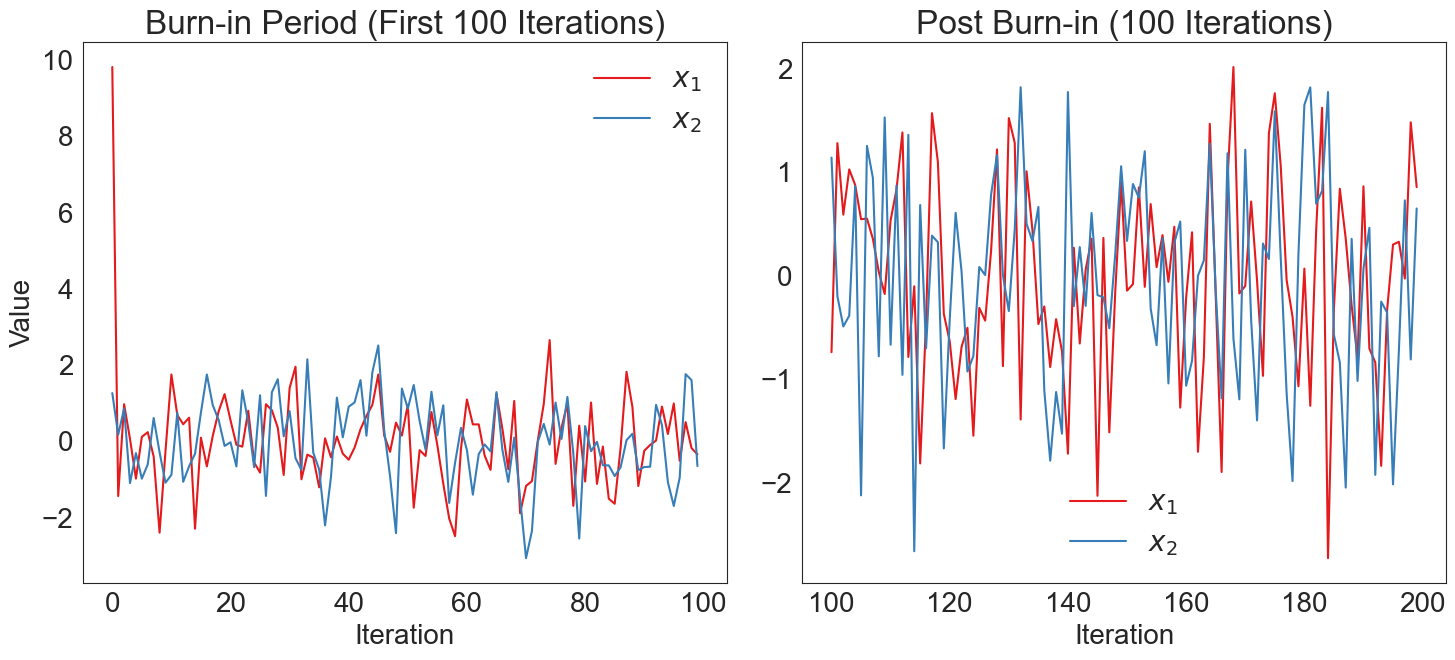

In [16]:
# Run Gibbs sampling with low correlation
n_samples = 10000
rho = 0.1
samples_low_corr = gibbs_sampler(n_samples, rho)

# Visualize the samples and burn-in period
plot_samples(samples_low_corr, n_burn=100, n_thin=10)
plot_chains(samples_low_corr, n_burn=100)

### Low Correlation Case (ρ = 0.1)

When we reduce the correlation coefficient to ρ = 0.1, we observe dramatically different sampling behavior:

With ρ = 0.1, the conditional distributions become:
- $p(x_1 | x_2) = \mathcal{N}(0.1 \times x_2, 0.99)$
- $p(x_2 | x_1) = \mathcal{N}(0.1 \times x_1, 0.99)$

Now the conditional mean depends only weakly on the other variable, and the conditional variance is much larger (0.99 compared to 0.0975 in the high-correlation case). This means each new sample has considerably more independence from the previous value.

#### More Efficient Exploration

The scatter plot reveals:
1. A more circular joint distribution (less elongated)
2. More random-looking placement of points throughout the distribution
3. Less visible zigzag pattern in the sampling trajectory

This occurs because when variables are less correlated, the coordinate-wise updates of Gibbs sampling become more effective at exploring the joint distribution. Each step can move more freely in its respective dimension.

#### Faster Convergence and Mixing

The chain trace plots demonstrate:
1. Much quicker burn-in - the chains rapidly approach their stationary distributions
2. More independent fluctuations between consecutive samples
3. Faster exploration of the full range of each variable

The chain appears to "forget" its starting position more quickly, which is a hallmark of efficient MCMC sampling. This faster mixing translates directly to a higher effective sample size.

### The Paradox of Gibbs Sampling

These two cases highlight an important insight about Gibbs sampling:

Even though Gibbs sampling always accepts proposed moves (unlike Metropolis-Hastings), it can still exhibit poor efficiency when variables are strongly correlated.**

This occurs because the algorithm is constrained to move parallel to the coordinate axes, one variable at a time. When the distribution has strong correlations that don't align with these axes, the sampler must take many small steps to explore the full distribution.


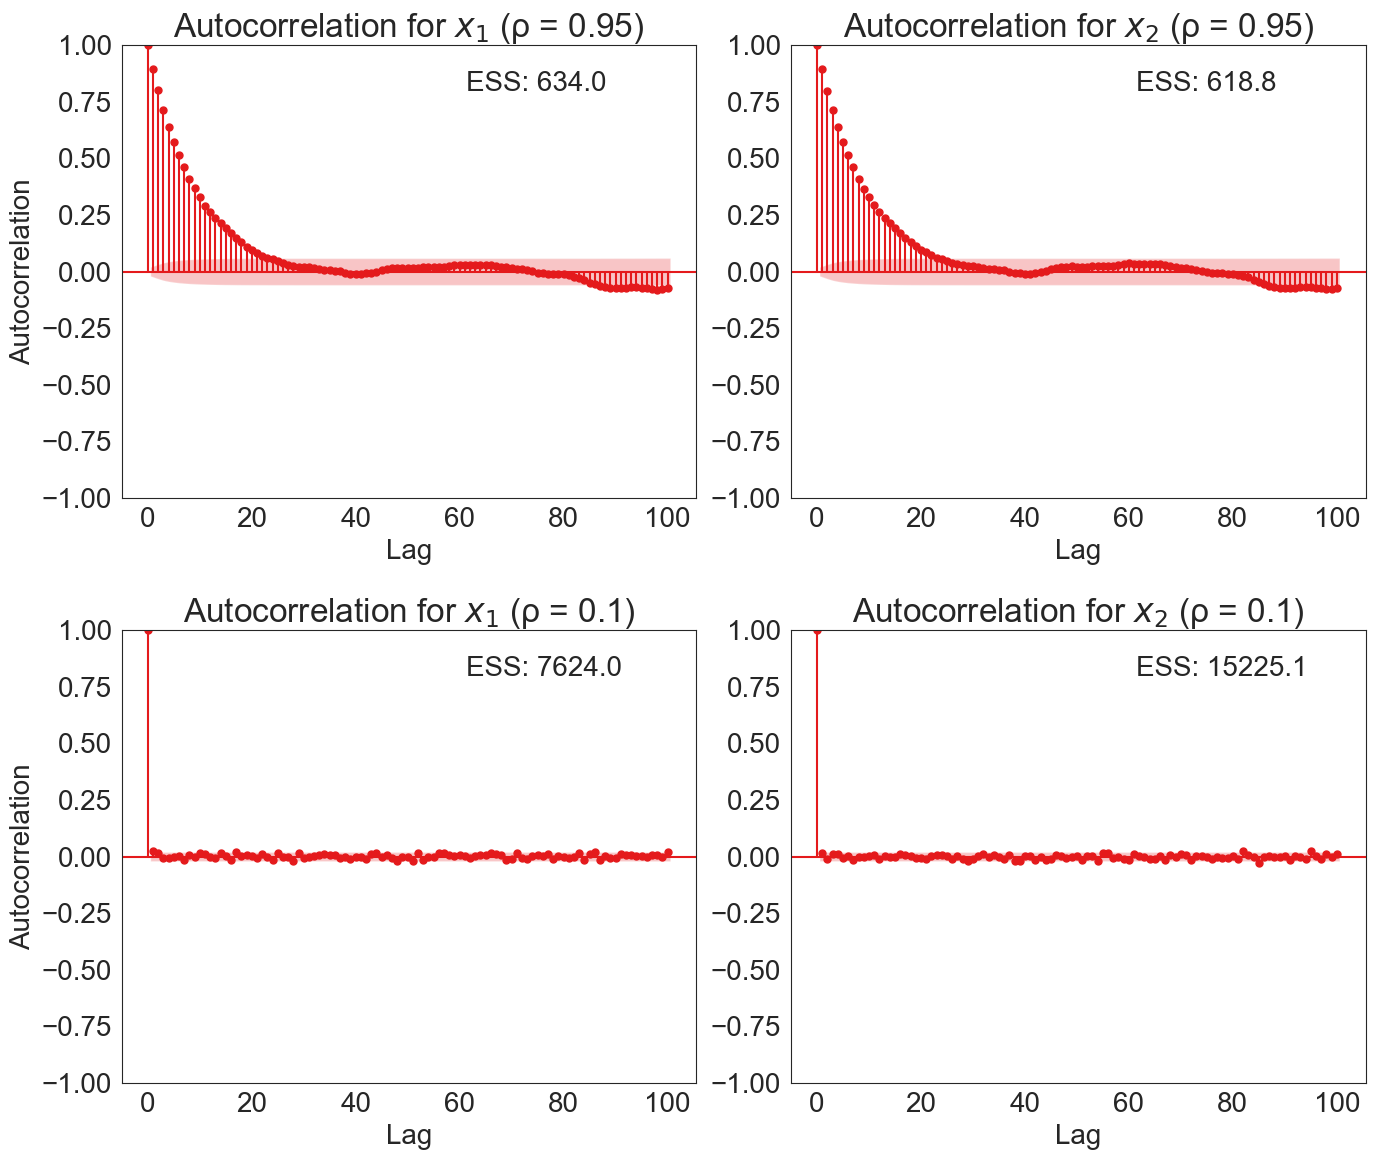

In [17]:
# Extract the samples for x1 and x2 variables from both chains
x1_high_corr = samples_high_corr[100:, 0]  # After burn-in
x2_high_corr = samples_high_corr[100:, 1]

x1_low_corr = samples_low_corr[100:, 0]  # After burn-in
x2_low_corr = samples_low_corr[100:, 1]

# Set up figure for autocorrelation plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# High correlation: autocorrelation for x1
sm.graphics.tsa.plot_acf(x1_high_corr, lags=100, ax=axes[0, 0])
axes[0, 0].set_title("Autocorrelation for $x_1$ (ρ = 0.95)")
axes[0, 0].set_xlabel("Lag")
axes[0, 0].set_ylabel("Autocorrelation")

# High correlation: autocorrelation for x2
sm.graphics.tsa.plot_acf(x2_high_corr, lags=100, ax=axes[0, 1])
axes[0, 1].set_title("Autocorrelation for $x_2$ (ρ = 0.95)")
axes[0, 1].set_xlabel("Lag")

# Low correlation: autocorrelation for x1
sm.graphics.tsa.plot_acf(x1_low_corr, lags=100, ax=axes[1, 0])
axes[1, 0].set_title("Autocorrelation for $x_1$ (ρ = 0.1)")
axes[1, 0].set_xlabel("Lag")
axes[1, 0].set_ylabel("Autocorrelation")

# Low correlation: autocorrelation for x2
sm.graphics.tsa.plot_acf(x2_low_corr, lags=100, ax=axes[1, 1])
axes[1, 1].set_title("Autocorrelation for $x_2$ (ρ = 0.1)")
axes[1, 1].set_xlabel("Lag")

# Calculate and display ESS for each variable
ess_x1_high = calculate_ess(x1_high_corr)
ess_x2_high = calculate_ess(x2_high_corr)
ess_x1_low = calculate_ess(x1_low_corr)
ess_x2_low = calculate_ess(x2_low_corr)

axes[0, 0].annotate(f"ESS: {ess_x1_high:.1f}", xy=(0.6, 0.9), xycoords='axes fraction')
axes[0, 1].annotate(f"ESS: {ess_x2_high:.1f}", xy=(0.6, 0.9), xycoords='axes fraction')
axes[1, 0].annotate(f"ESS: {ess_x1_low:.1f}", xy=(0.6, 0.9), xycoords='axes fraction')
axes[1, 1].annotate(f"ESS: {ess_x2_low:.1f}", xy=(0.6, 0.9), xycoords='axes fraction')

plt.tight_layout()
plt.show()

### Autocorrelation Analysis: Quantifying Sampling Efficiency

The autocorrelation plots provide a quantitative measure of the sampling efficiency differences we observed visually. Let's interpret these results:

#### High Correlation Case (ρ = 0.95)

The autocorrelation plots for the high correlation scenario reveal:

1. **Persistent Autocorrelation**: The correlation between samples remains significant even at high lag values. This indicates that samples separated by many iterations still contain redundant information.

2. **Oscillatory Pattern**: Notice the distinctive alternating pattern in the autocorrelation function. This reflects the zigzag sampling behavior, where the chain oscillates back and forth.

3. **Low Effective Sample Size (ESS)**: Despite generating 10,000 samples, the effective number of independent samples is much smaller. This quantifies the inefficiency of the sampling process - we're getting far fewer "truly independent" samples than the raw count suggests.

#### Low Correlation Case (ρ = 0.1)

The autocorrelation plots for the low correlation scenario show:

1. **Rapid Decay**: The autocorrelation drops much more quickly, approaching zero after just a few lags. This indicates that samples become effectively independent after fewer iterations.

2. **Minimal Oscillation**: The alternating pattern is much less pronounced, reflecting more direct exploration of the joint distribution.

3. **Higher Effective Sample Size**: The ESS is substantially larger than in the high correlation case, confirming that the sampling is more efficient. We're getting more "information value" per sample.

#### Implications for MCMC Practice

These results highlight several practical considerations for MCMC sampling:

1. **Coordinate System Matters**: Gibbs sampling works best when variables are approximately independent in the chosen coordinate system. When strong correlations exist, consider:
   - Reparameterizing the model to reduce correlations
   - Using block updates that sample correlated variables together
   - Switching to algorithms that adapt to the correlation structure

2. **Effective Sample Size, Not Raw Sample Count**: When reporting results from MCMC analyses, the effective sample size provides a more honest assessment of the precision of your estimates than the raw number of samples.

3. **Correlation-Aware Diagnostics**: Always check for autocorrelation when using MCMC methods. High autocorrelation is a warning sign that you may need more samples or a different sampling approach.

In astronomical applications, where models often have complex parameter correlations, these considerations are particularly important. Naive application of Gibbs sampling to highly correlated parameters can lead to inefficient use of computational resources and potentially misleading uncertainty estimates.

## Summary

In this tutorial, we've explored two fundamental MCMC techniques—the Metropolis algorithm and Gibbs sampling—that have revolutionized statistical inference in astronomy. These methods allow us to sample from complex probability distributions and perform Bayesian inference even when analytical solutions aren't available.

The **Metropolis algorithm** offers versatility, sampling from virtually any distribution where we can evaluate the density up to a normalizing constant. However, tuning the proposal distribution is critical—too narrow and the chain explores inefficiently, too wide and the acceptance rate plummets. Diagnostic tools like acceptance rates, autocorrelation analysis, and convergence tests provide essential quality checks.

**Gibbs sampling** excels when conditional distributions are easy to sample from but struggles with strongly correlated variables. While it always accepts proposed moves, it can still exhibit poor mixing when the target distribution has correlations not aligned with the coordinate axes.

Both methods require attention to common challenges: discarding the burn-in period until the chain reaches its stationary distribution, accounting for autocorrelation that reduces effective sample size, and applying convergence tests to ensure reliable results.

By understanding the strengths and limitations of MCMC methods, you can leverage these powerful tools to extract reliable insights from astronomical observations. The journey from the simple idea of a random walk through parameter space to sophisticated statistical inference exemplifies how computational methods continue to expand the horizons of astronomical discovery.